<a href="https://colab.research.google.com/github/robgon-art/contrastive-similarity-test/blob/main/Contrastive_Similarity_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/robgon-art/contrastive-similarity-test

Cloning into 'contrastive-similarity-test'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 40 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (40/40), done.


In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

In [5]:
import clip
print(clip.available_models())

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


In [6]:
import torch
import clip
from PIL import Image
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14@336px", device=device)

100%|███████████████████████████████████████| 891M/891M [00:23<00:00, 39.5MiB/s]


In [7]:
res = model.visual.input_resolution
print(res)

336


In [8]:
import glob
file_list = glob.glob("/content/contrastive-similarity-test/images/*.png")
file_list.sort()

 0.0015  0.0103 0 v1-1 /content/contrastive-similarity-test/images/mjv1.png
-0.0078  0.0133 0 v1-2 /content/contrastive-similarity-test/images/mjv1.png
-0.0081  0.0294 0 v1-3 /content/contrastive-similarity-test/images/mjv1.png
 0.0024  0.0442 0 v1-4 /content/contrastive-similarity-test/images/mjv1.png
-0.0027  0.0273 1 v2-1 /content/contrastive-similarity-test/images/mjv2.png
-0.0146  0.0192 1 v2-2 /content/contrastive-similarity-test/images/mjv2.png
-0.0198 -0.0106 1 v2-3 /content/contrastive-similarity-test/images/mjv2.png
 0.0000  0.0188 1 v2-4 /content/contrastive-similarity-test/images/mjv2.png
 0.0068  0.0356 2 v3-1 /content/contrastive-similarity-test/images/mjv3.png
-0.0024  0.0410 2 v3-2 /content/contrastive-similarity-test/images/mjv3.png
-0.0007  0.0234 2 v3-3 /content/contrastive-similarity-test/images/mjv3.png
-0.0073  0.0182 2 v3-4 /content/contrastive-similarity-test/images/mjv3.png
-0.0024  0.0673 3 v4-1 /content/contrastive-similarity-test/images/mjv4.png
 0.0076  0.0

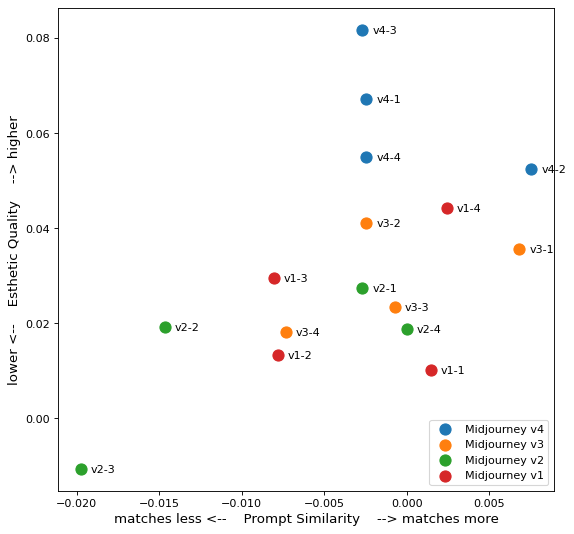

In [9]:
from IPython.display import display
prompt_similarities = []
esthetic_qualities = []
labels = []

prompt = "painting of a French man wearing a hat drinking wine at an outdoor cafe"

inaccurate_prompt = "inaccurate " + prompt
accurate_prompt = "accurate " + prompt
fake_prompt = "fake " + prompt
real_prompt = "real " + prompt

text = clip.tokenize(["ugly art", "beautiful art", "bad art", "good art", inaccurate_prompt, accurate_prompt, fake_prompt, real_prompt]).to(device)

with torch.no_grad():
  text_features = model.encode_text(text)
  text_features /= text_features.norm(dim=-1, keepdim=True)

for v, f in enumerate(file_list):
  version = f[-6:-4]

  img = Image.open(f)
  img_resized = img.resize((512, 512), resample=Image.BICUBIC)

  count = 1

  for j in range(2):
    for i in range(2):
      label = version + "-" + str(count)
      labels.append(label)

      # print(v, f, label)
      count += 1

      img_cropped = img_resized.crop((i*256, j*256, (i+1)*256, (j+1)*256))
      image = preprocess(img_cropped).unsqueeze(0).to(device)

      with torch.no_grad():
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

      ugly = similarity[0][0]
      beautiful = similarity[1][0]
      bad = similarity[2][0]
      good = similarity[3][0]
      esthetic_quality = (beautiful-ugly) + (good-bad)

      inaccurate_prompt = similarity[4][0]
      accurate_prompt = similarity[5][0]
      fake_prompt = similarity[6][0]
      real_prompt = similarity[7][0]
      prompt_similarity = (accurate_prompt-inaccurate_prompt) + (real_prompt-fake_prompt)

      prompt_similarities.append(esthetic_quality)
      esthetic_qualities.append(prompt_similarity)

      print("{:7.4f}".format(prompt_similarity), "{:7.4f}".format(esthetic_quality), v, label, f)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
plt.xlabel("matches less <--    Prompt Similarity    --> matches more", fontsize=12)
plt.ylabel("lower <--    Esthetic Quality    --> higher", fontsize=12)
plt.scatter(esthetic_qualities[12:16], prompt_similarities[12:16], s=100, label="Midjourney v4")
plt.scatter(esthetic_qualities[8:12], prompt_similarities[8:12], s=100, label="Midjourney v3")
plt.scatter(esthetic_qualities[4:8], prompt_similarities[4:8], s=100, label="Midjourney v2")
plt.scatter(esthetic_qualities[0:4], prompt_similarities[0:4], s=100, label="Midjourney v1")
plt.legend(loc="lower right")

for i, txt in enumerate(labels):
  ax.annotate(txt, (esthetic_qualities[i]+0.0006, prompt_similarities[i]-0.00075))
plt.show()

In [10]:
print(similarity.shape)

(8, 1)
